In [1]:
import umap
import prince
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Dataset of labeled pulsars and their characteristics
data = pd.read_csv('data/pulsar_stars.csv')
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [4]:
# Seperate out the labels
X = data.iloc[:, :8].copy()
y = data.iloc[:, 8].copy()

In [5]:
# handle potential outliers
for col in X.columns:
    winsorized = winsorize(data[col], (0, .03))
    X[col + " winsorized"] = winsorized
    X.drop(col, axis=1, inplace=True)

In [6]:
scale = StandardScaler()
scaled = scale.fit_transform(X)

### KMeans Clustering:

In [7]:
# Find initial best clusters with Kmeans by using the elbow method of inertia comparison
def get_scores(scaled, y):
    inertia = []
    k_list = []
    scores = []
    for k in range(1, 10, 1):
        model = KMeans(n_clusters=k, n_jobs=8)
        clusters = model.fit(scaled)
        inertia.append(clusters.inertia_)
        k_list.append(k)
        scores.append(adjusted_rand_score(y, clusters.predict(scaled)))
    kmeans = pd.DataFrame({'k':k_list, "inertia":inertia})
    plt.plot(kmeans['k'], kmeans['inertia'])
    return k_list, scores

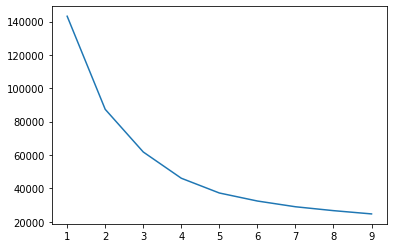

In [8]:
k_list, scores = get_scores(scaled, y)

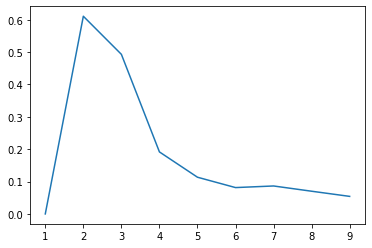

In [9]:
plt.plot(k_list, scores)

In [10]:
# refit model with best scoring cluster
prediction = KMeans(n_clusters=2, n_jobs=8).fit_predict(scaled)

score = adjusted_rand_score(y, prediction)
score

0.6108819557585196

In [11]:
# Function to assign colors
palette = ['r', 'b', 'y', 'g', 'violet', 'orange', 'indigo']

In [12]:
pca = PCA(n_components=2)
pca_2components = pca.fit_transform(scaled)

In [13]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.2,
                      metric='correlation').fit_transform(scaled)

In [14]:
def dualmaps(pca_components, umap_components, num_clusters, labels, palette):
    p = palette[:num_clusters]
    fig= plt.subplots(figsize=(8,6))
    plt.subplot(1,2,1)
    plt.title('UMAP Cluster Results')
    sns.scatterplot(x=umap_components[:, 0], y=umap_components[:, 1], hue=labels, palette=p)

    plt.subplot(1,2,2)
    plt.title('PCA Cluster Results')
    sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels, palette=p)

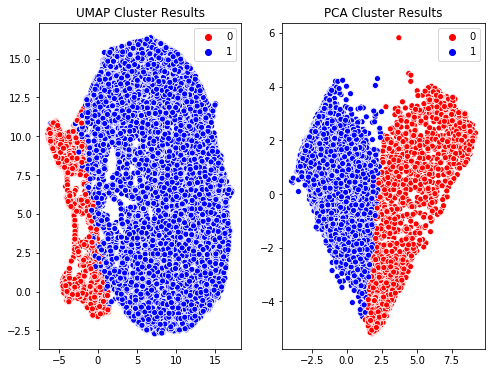

In [15]:
dualmaps(pca_2components, umap_results, 2, prediction, palette)

K means was able to group the categories correctly with about a 61% accuracy and by using two different dimensionality reduction techniques, we can see how the groupings differ in two dimensional space.